# Importing Libraries

In [1]:
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import splitfolders
import PIL
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import glob
import cv2
import seaborn as sns
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50
from tensorflow.keras.layers import Input, Flatten, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os, shutil
import sys
import shutil
import json
import glob as gb
import dlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
videos_folder = "train_sample_videos"


metadata_file = os.path.join(videos_folder, "metadata.json")

with open(metadata_file, 'r') as json_file:
    metadata = json.load(json_file)


for video_filename, video_info in metadata.items():
    label = video_info["label"]
    source_path = os.path.join(videos_folder, video_filename)
    destination_folder = os.path.join(videos_folder, label.upper())


    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    
    destination_path = os.path.join(destination_folder, video_filename)
    shutil.move(source_path, destination_path)

# Preparing the dataset

In [3]:
real_videos_folder = 'train_sample_videos/REAL'
fake_videos_folder = 'train_sample_videos/FAKE'

def process_videos(video_folder, output_folder):
    list_of_data = [f for f in os.listdir(video_folder) if f.endswith('.mp4')]
    detector = dlib.get_frontal_face_detector()

    for vid in list_of_data:
        count = 0
        cap = cv2.VideoCapture(os.path.join(video_folder, vid))

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret or frame is None or frame.size == 0:
                break

            face_rects, _, _ = detector.run(frame, 0)

            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]

                if crop_img.size != 0:
                    resized_img = cv2.resize(crop_img, (128, 128))
                    cv2.imwrite(os.path.join(output_folder, vid.split('.')[0] + '_' + str(count) + '.png'), resized_img)
                    count += 1

    cap.release()

In [4]:
process_videos(real_videos_folder, 'data/real')

In [5]:
process_videos(fake_videos_folder, 'data/fake')

# Loading the dataset

In [6]:

class config:
    
    data_path = 'data/'
    
    path_train = "./output/train"
    path_test = "./output/test"

In [7]:
splitfolders.ratio(config.data_path, output="output", seed=101, ratio=(.8, .2))

Copying files: 111472 files [01:05, 1699.68 files/s]


# EDA

In [8]:
BATCH_SIZE = 64
IMAGE_SHAPE = (128, 128)

In [9]:
TRAIN_PATH = "output/train"
VAL_PATH = "output/val"

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

val_gen = datagen.flow_from_directory(directory = VAL_PATH, 
                                          class_mode="categorical",
                                          target_size = IMAGE_SHAPE,
                                          batch_size = BATCH_SIZE,
                                          color_mode='rgb',
                                          seed = 1234,
                                          shuffle = True)

Found 89177 images belonging to 2 classes.
Found 22295 images belonging to 2 classes.


# Data Visualization

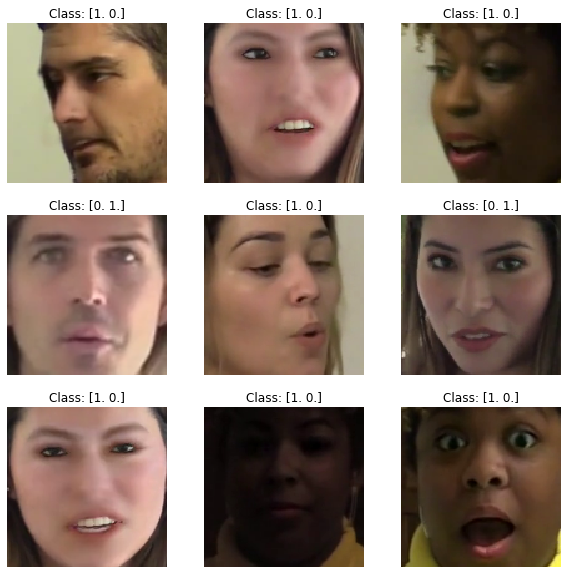

In [11]:
def plot_images(generator, num_images=9):
    
    images, labels = generator.next()

    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {labels[i]}')
        plt.axis('off')
    
    plt.show()


plot_images(train_gen)



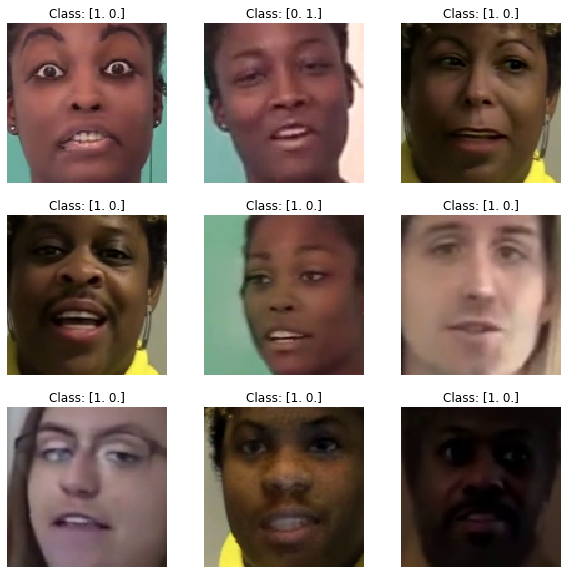

In [12]:
plot_images(val_gen)

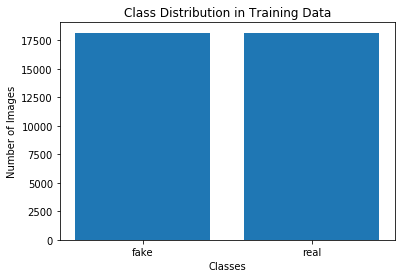

In [13]:
class_counts = np.sum(train_gen.labels, axis=0)
classes = list(train_gen.class_indices.keys())

plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Data')
plt.show()

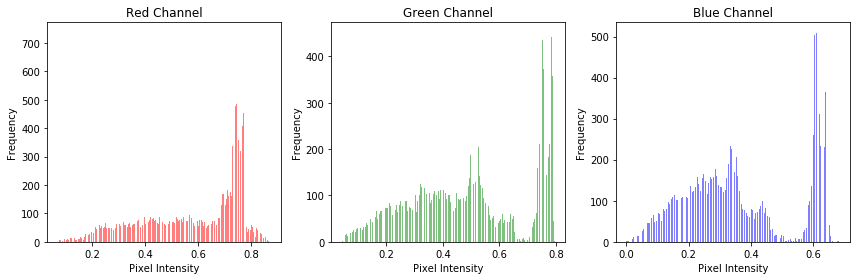

In [14]:
def plot_pixel_intensity(image):
    plt.figure(figsize=(12, 4))

   
    plt.subplot(1, 3, 1)
    plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5, rwidth=0.8)
    plt.title('Red Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 2)
    plt.hist(image[:, :, 1].ravel(), bins=256, color='green', alpha=0.5, rwidth=0.8)
    plt.title('Green Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    
    plt.subplot(1, 3, 3)
    plt.hist(image[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5, rwidth=0.8)
    plt.title('Blue Channel')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


sample_image = train_gen[0][0][0]  
plot_pixel_intensity(sample_image)

# Model Building

### Inception-ResNet-v2

In [15]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [16]:
inc = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 333s 231ms/step - loss: 0.1092 - accuracy: 0.9670 - f1_score: 0.9670 - recall_m: 0.9670 - precision_m: 0.9670 - specificity_m: 0.9670 - sensitivity_m: 0.9670 - mae: 0.0502 - mse: 0.0254 - val_loss: 1.4641 - val_accuracy: 0.9769 - val_f1_score: 0.9769 - val_recall_m: 0.9769 - val_precision_m: 0.9769 - val_specificity_m: 0.9769 - val_sensitivity_m: 0.9769 - val_mae: 0.0336 - val_mse: 0.0191
Epoch 2/50
1394/1394 [==============================] - 112s 81ms/step - loss: 0.0416 - accuracy: 0.9859 - f1_score: 0.9859 - recall_m: 0.9859 - precision_m: 0.9859 - specificity_m: 0.9859 - sensitivity_m: 0.9859 - mae: 0.0212 - mse: 0.0106 - val_loss: 0.1806 - val_accuracy: 0.9587 - val_f1_score: 0.9588 - val_recall_m: 0.9588 - val_precision_m: 0.9588 - val_specificity_m: 0.9588 - val_sensitivity_m: 0.9588 - val_mae: 0.0637 - val_mse: 0.0307
Epoch 3/50
1394/1394 [==============================] - 114s 82ms/step - loss: 0.1319 - accuracy: 0.9561 

In [18]:
model.save('models/Inceptionresnet_v2.h5')

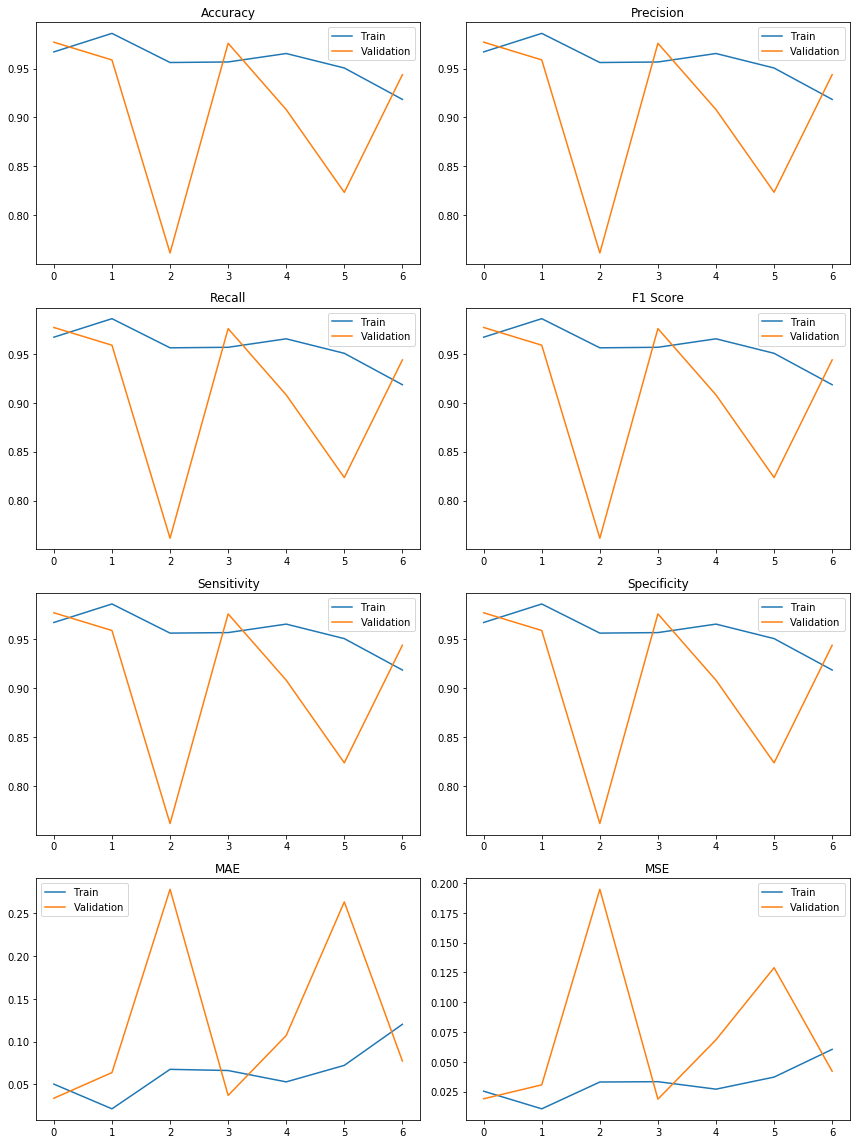

In [19]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 13s 36ms/step - loss: 0.1407 - accuracy: 0.9437 - f1_score: 0.9438 - recall_m: 0.9438 - precision_m: 0.9438 - specificity_m: 0.9438 - sensitivity_m: 0.9438 - mae: 0.0773 - mse: 0.0421


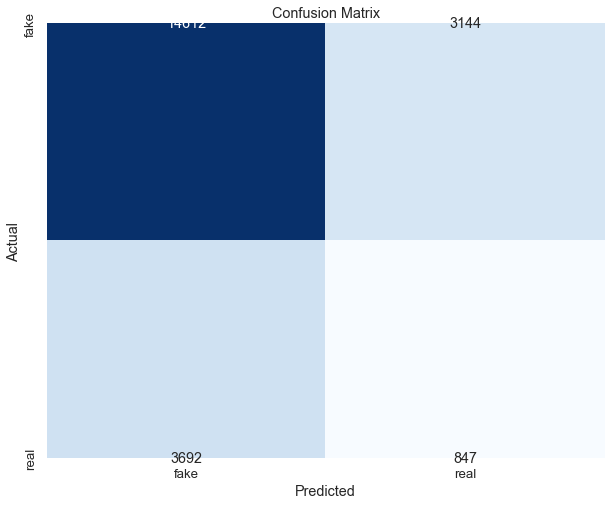

In [20]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [21]:
a = history.history['accuracy'][-1]
f = history.history['f1_score'][-1]
p = history.history['precision_m'][-1]
r = history.history['recall_m'][-1]
mae = history.history['mae'][-1]
mse = history.history['mse'][-1]
specificity = history.history['specificity_m'][-1]  
sensitivity = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a * 100))
print('Precision = ' + str(p * 100))
print('F1 Score = ' + str(f * 100))
print('Recall = ' + str(r * 100))
print('MAE = ' + str(mae))
print('MSE = ' + str(mse))
print('Sensitivity = ' + str(sensitivity * 100))  
print('Specificity = ' + str(specificity * 100))

Accuracy = 91.84318780899048
Precision = 91.84150695800781
F1 Score = 91.84150099754333
Recall = 91.84150695800781
MAE = 0.12021854519844055
MSE = 0.060502566397190094
Sensitivity = 91.84150695800781
Specificity = 91.84150695800781


# VGG19

In [22]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [23]:
inc = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [24]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 80s 56ms/step - loss: 0.7760 - accuracy: 0.7945 - f1_score: 0.7944 - recall_m: 0.7944 - precision_m: 0.7944 - specificity_m: 0.7944 - sensitivity_m: 0.7944 - mae: 0.3239 - mse: 0.1632 - val_loss: 0.5066 - val_accuracy: 0.7964 - val_f1_score: 0.7962 - val_recall_m: 0.7962 - val_precision_m: 0.7962 - val_specificity_m: 0.7962 - val_sensitivity_m: 0.7962 - val_mae: 0.3126 - val_mse: 0.1627
Epoch 2/50
1394/1394 [==============================] - 77s 55ms/step - loss: 0.5065 - accuracy: 0.7964 - f1_score: 0.7964 - recall_m: 0.7964 - precision_m: 0.7964 - specificity_m: 0.7964 - sensitivity_m: 0.7964 - mae: 0.3243 - mse: 0.1625 - val_loss: 0.5070 - val_accuracy: 0.7964 - val_f1_score: 0.7962 - val_recall_m: 0.7962 - val_precision_m: 0.7962 - val_specificity_m: 0.7962 - val_sensitivity_m: 0.7962 - val_mae: 0.3110 - val_mse: 0.1628
Epoch 3/50
1394/1394 [==============================] - 76s 55ms/step - loss: 0.5072 - accuracy: 0.7964 - f1

In [25]:
model.save('models/vgg19.h5')

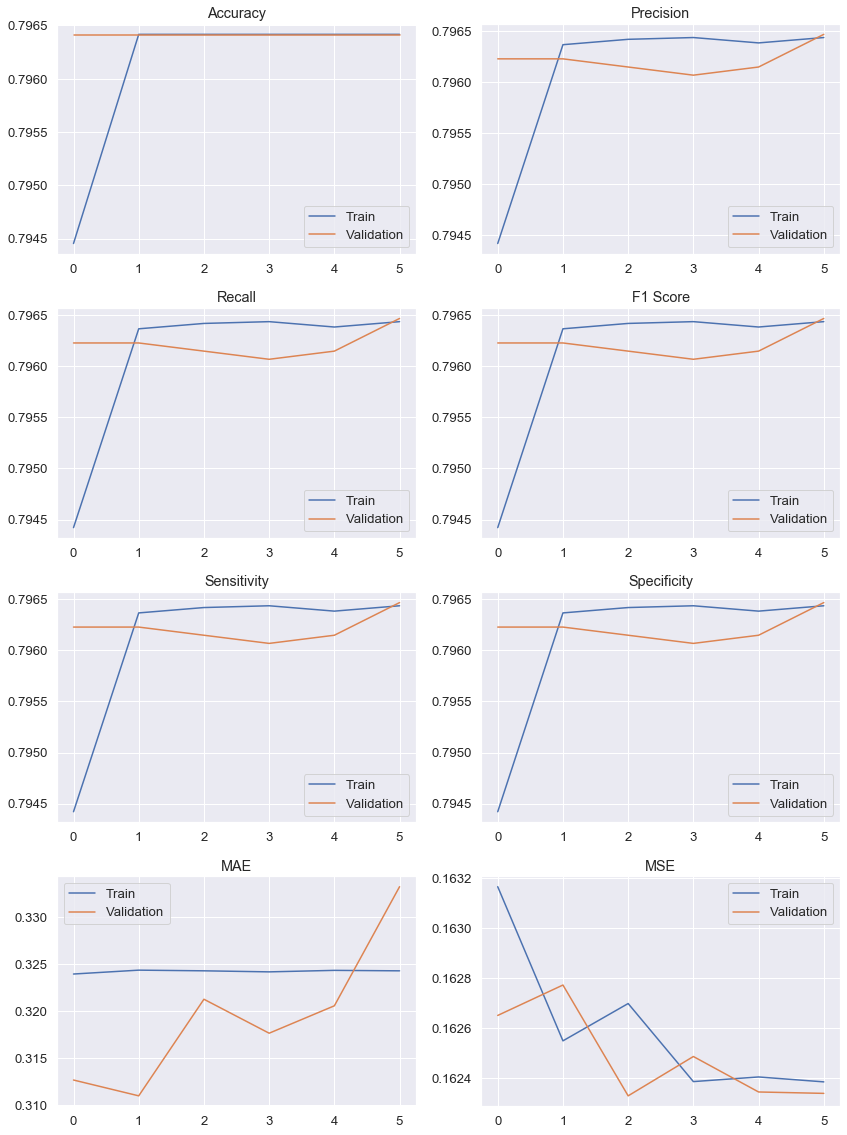

In [26]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 12s 35ms/step - loss: 0.5060 - accuracy: 0.7964 - f1_score: 0.7961 - recall_m: 0.7961 - precision_m: 0.7961 - specificity_m: 0.7961 - sensitivity_m: 0.7961 - mae: 0.3335 - mse: 0.1626


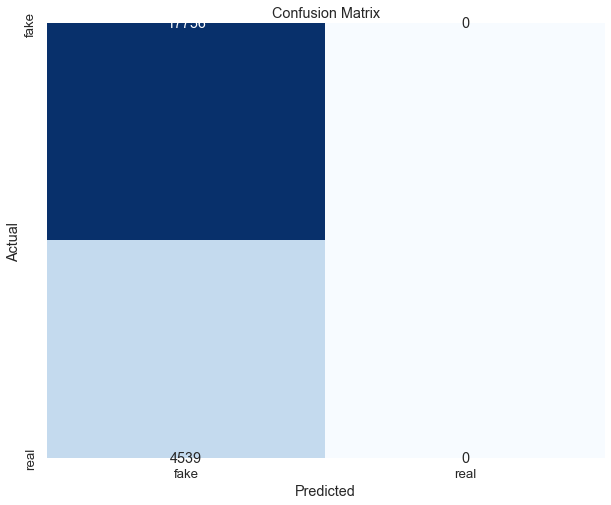

In [27]:
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
a1 = history.history['accuracy'][-1]
f1 = history.history['f1_score'][-1]
p1 = history.history['precision_m'][-1]
r1 = history.history['recall_m'][-1]
mae1 = history.history['mae'][-1]
mse1 = history.history['mse'][-1]
specificity1 = history.history['specificity_m'][-1]  
sensitivity1 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a1 * 100))
print('Precision = ' + str(p1 * 100))
print('F1 Score = ' + str(f1 * 100))
print('Recall = ' + str(r1 * 100))
print('MAE = ' + str(mae1))
print('MSE = ' + str(mse1))
print('Sensitivity = ' + str(sensitivity1 * 100))  
print('Specificity = ' + str(specificity1 * 100))

Accuracy = 79.64161038398743
Precision = 79.64351177215576
F1 Score = 79.64351177215576
Recall = 79.64351177215576
MAE = 0.3242703676223755
MSE = 0.16238461434841156
Sensitivity = 79.64351177215576
Specificity = 79.64351177215576


# CNN

In [29]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [30]:
model = models.Sequential() 


model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[128, 128, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_203 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_204 (Conv2D)          (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [31]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 64s 45ms/step - loss: 0.2732 - accuracy: 0.8847 - f1_score: 0.8847 - recall_m: 0.8847 - precision_m: 0.8847 - specificity_m: 0.8847 - sensitivity_m: 0.8847 - mae: 0.1722 - mse: 0.0845 - val_loss: 0.1173 - val_accuracy: 0.9524 - val_f1_score: 0.9525 - val_recall_m: 0.9525 - val_precision_m: 0.9525 - val_specificity_m: 0.9525 - val_sensitivity_m: 0.9525 - val_mae: 0.0694 - val_mse: 0.0342
Epoch 2/50
1394/1394 [==============================] - 61s 44ms/step - loss: 0.1108 - accuracy: 0.9565 - f1_score: 0.9566 - recall_m: 0.9566 - precision_m: 0.9566 - specificity_m: 0.9566 - sensitivity_m: 0.9566 - mae: 0.0653 - mse: 0.0323 - val_loss: 0.0811 - val_accuracy: 0.9690 - val_f1_score: 0.9689 - val_recall_m: 0.9689 - val_precision_m: 0.9689 - val_specificity_m: 0.9689 - val_sensitivity_m: 0.9689 - val_mae: 0.0477 - val_mse: 0.0232
Epoch 3/50
1394/1394 [==============================] - 61s 44ms/step - loss: 0.0762 - accuracy: 0.9708 - f1

In [32]:
model.save('models/cnn.h5')

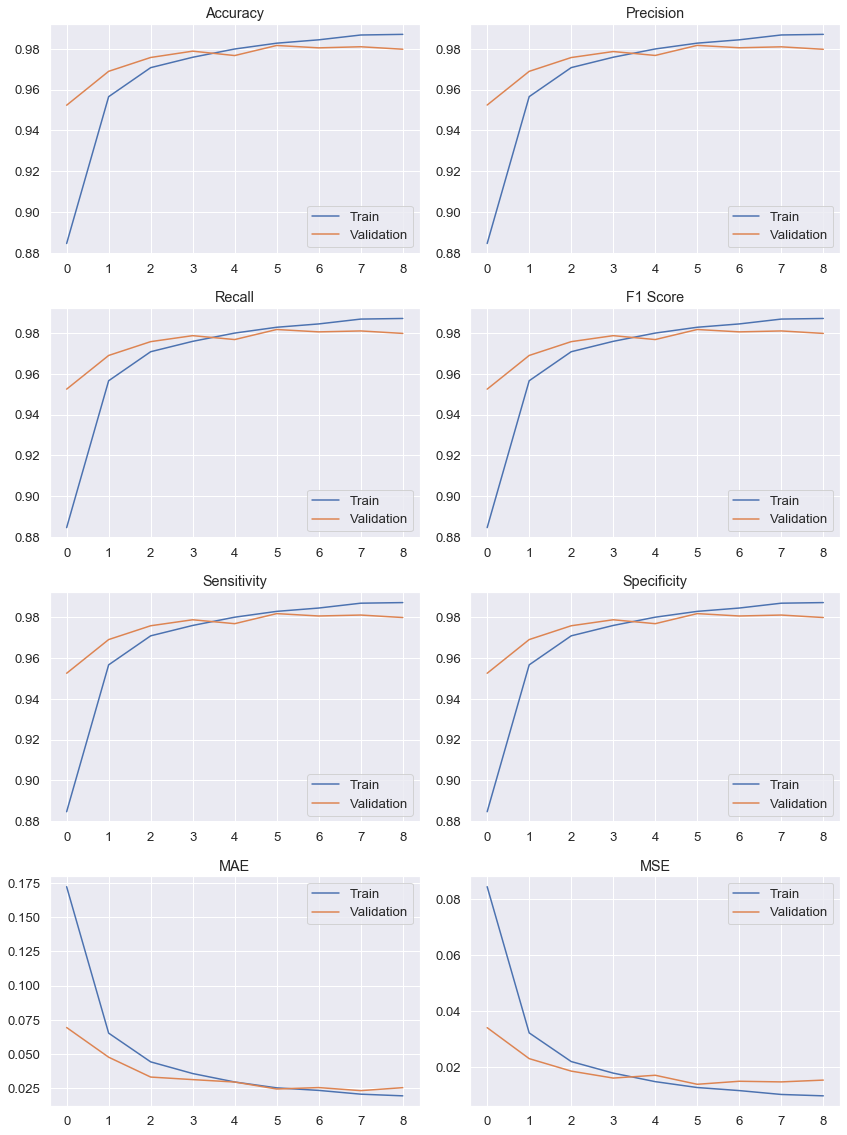

In [33]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 12s 36ms/step - loss: 0.0591 - accuracy: 0.9798 - f1_score: 0.9797 - recall_m: 0.9797 - precision_m: 0.9797 - specificity_m: 0.9797 - sensitivity_m: 0.9797 - mae: 0.0255 - mse: 0.0155


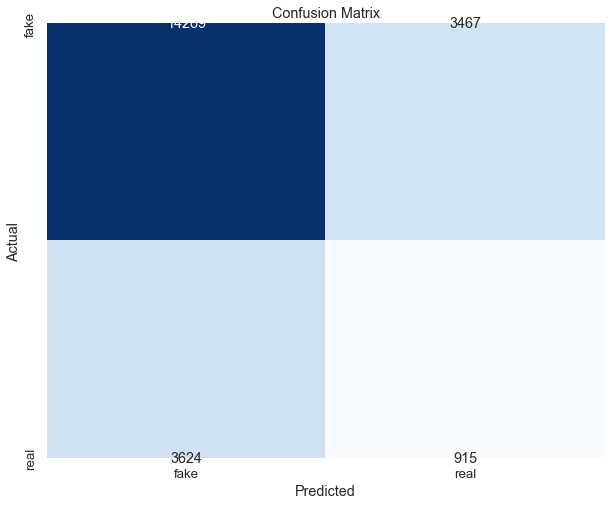

In [34]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [35]:
a2 = history.history['accuracy'][-1]
f2 = history.history['f1_score'][-1]
p2 = history.history['precision_m'][-1]
r2 = history.history['recall_m'][-1]
mae2 = history.history['mae'][-1]
mse2 = history.history['mse'][-1]
specificity2 = history.history['specificity_m'][-1]  
sensitivity2 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a2 * 100))
print('Precision = ' + str(p2 * 100))
print('F1 Score = ' + str(f2 * 100))
print('Recall = ' + str(r2 * 100))
print('MAE = ' + str(mae2))
print('MSE = ' + str(mse2))
print('Sensitivity = ' + str(sensitivity2 * 100))  
print('Specificity = ' + str(specificity2 * 100))

Accuracy = 98.70482087135315
Precision = 98.7036406993866
F1 Score = 98.7036406993866
Recall = 98.7036406993866
MAE = 0.019514378160238266
MSE = 0.00987741444259882
Sensitivity = 98.7036406993866
Specificity = 98.7036406993866


# Xception

In [36]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def specificity_m(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity

def sensitivity_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sensitivity = true_positives / (possible_positives + K.epsilon())
    return sensitivity

def mae(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) 

In [37]:
inc = tf.keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')


x31 = Flatten()(inc.output)
predictionss = Dense(2, activation='softmax')(x31)


model = Model(inputs = inc.inputs, outputs = predictionss)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [38]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_score, recall_m, precision_m, specificity_m, sensitivity_m, mae, mse])
history = model.fit(train_gen, validation_data=val_gen, epochs=50, steps_per_epoch=len(train_gen), validation_steps=len(val_gen), callbacks=[early_stopping_callback])

Epoch 1/50
1394/1394 [==============================] - 117s 82ms/step - loss: 0.0835 - accuracy: 0.9679 - f1_score: 0.9679 - recall_m: 0.9679 - precision_m: 0.9679 - specificity_m: 0.9679 - sensitivity_m: 0.9679 - mae: 0.0477 - mse: 0.0239 - val_loss: 0.0473 - val_accuracy: 0.9815 - val_f1_score: 0.9815 - val_recall_m: 0.9815 - val_precision_m: 0.9815 - val_specificity_m: 0.9815 - val_sensitivity_m: 0.9815 - val_mae: 0.0256 - val_mse: 0.0134
Epoch 2/50
1394/1394 [==============================] - 114s 82ms/step - loss: 0.0298 - accuracy: 0.9896 - f1_score: 0.9896 - recall_m: 0.9896 - precision_m: 0.9896 - specificity_m: 0.9896 - sensitivity_m: 0.9896 - mae: 0.0164 - mse: 0.0081 - val_loss: 0.0490 - val_accuracy: 0.9827 - val_f1_score: 0.9826 - val_recall_m: 0.9826 - val_precision_m: 0.9826 - val_specificity_m: 0.9826 - val_sensitivity_m: 0.9826 - val_mae: 0.0243 - val_mse: 0.0135
Epoch 3/50
1394/1394 [==============================] - 114s 81ms/step - loss: 0.0225 - accuracy: 0.9921 -

In [39]:
model.save('models/Xception.h5')

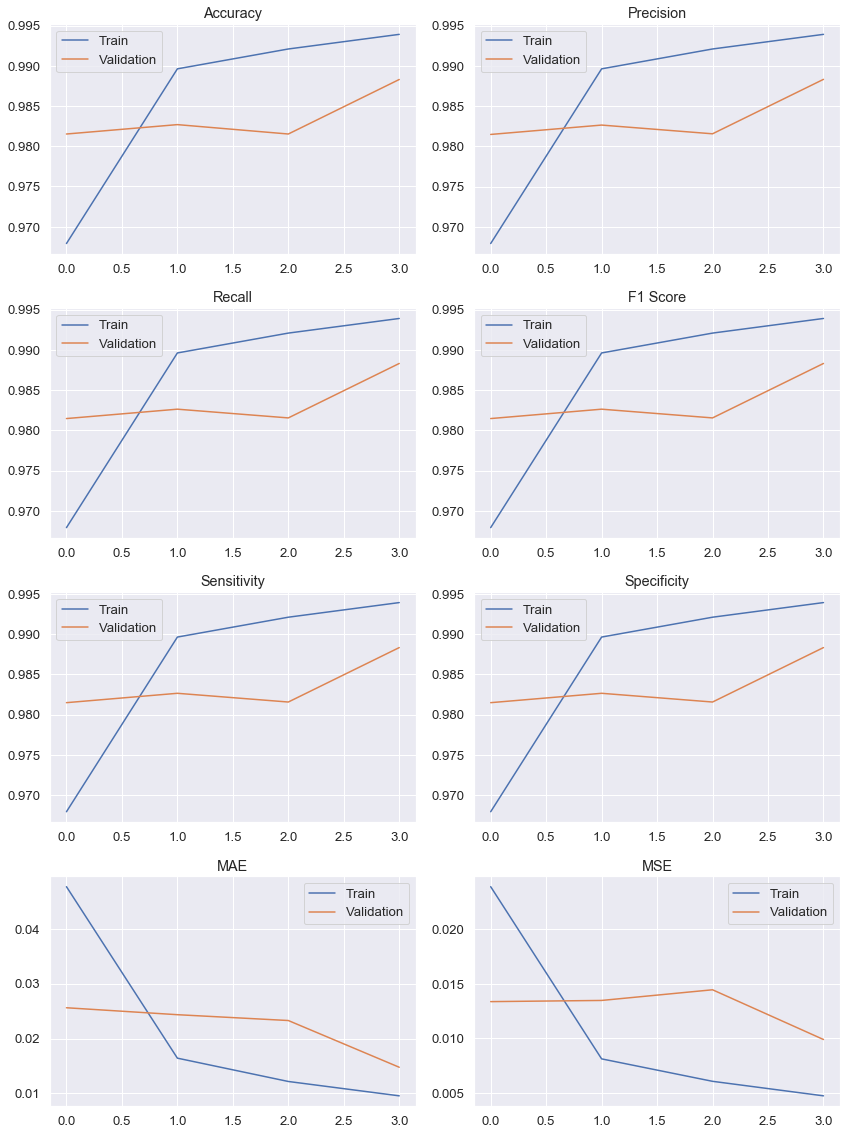

In [40]:
train_acc = history.history['accuracy']
train_recall = history.history['recall_m']
train_precision = history.history['precision_m']
train_f1 = history.history['f1_score']
train_sensitivity = history.history['sensitivity_m']
train_specificity = history.history['specificity_m']

val_acc = history.history['val_accuracy']
val_recall = history.history['val_recall_m']
val_precision = history.history['val_precision_m']
val_f1 = history.history['val_f1_score']
val_sensitivity = history.history['val_sensitivity_m']
val_specificity = history.history['val_specificity_m']

train_mae = history.history['mae'] 
train_mse = history.history['mse']  

val_mae = history.history['val_mae']  
val_mse = history.history['val_mse']


fig, axs = plt.subplots(4, 2, figsize=(12, 16))  # 4 rows, 2 columns

# Plot accuracy
axs[0, 0].plot(train_acc, label='Train')
axs[0, 0].plot(val_acc, label='Validation')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend()

# Plot precision
axs[0, 1].plot(train_precision, label='Train')
axs[0, 1].plot(val_precision, label='Validation')
axs[0, 1].set_title('Precision')
axs[0, 1].legend()

# Plot recall
axs[1, 0].plot(train_recall, label='Train')
axs[1, 0].plot(val_recall, label='Validation')
axs[1, 0].set_title('Recall')
axs[1, 0].legend()

# Plot F1 score
axs[1, 1].plot(train_f1, label='Train')
axs[1, 1].plot(val_f1, label='Validation')
axs[1, 1].set_title('F1 Score')
axs[1, 1].legend()

# Plot sensitivity
axs[2, 0].plot(train_sensitivity, label='Train')
axs[2, 0].plot(val_sensitivity, label='Validation')
axs[2, 0].set_title('Sensitivity')
axs[2, 0].legend()

# Plot specificity
axs[2, 1].plot(train_specificity, label='Train')
axs[2, 1].plot(val_specificity, label='Validation')
axs[2, 1].set_title('Specificity')
axs[2, 1].legend()

# Plot MAE
axs[3, 0].plot(train_mae, label='Train')
axs[3, 0].plot(val_mae, label='Validation')
axs[3, 0].set_title('MAE')
axs[3, 0].legend()

# Plot MSE
axs[3, 1].plot(train_mse, label='Train')
axs[3, 1].plot(val_mse, label='Validation')
axs[3, 1].set_title('MSE')
axs[3, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

349/349 [==============================] - 12s 35ms/step - loss: 0.0489 - accuracy: 0.9883 - f1_score: 0.9883 - recall_m: 0.9883 - precision_m: 0.9883 - specificity_m: 0.9883 - sensitivity_m: 0.9883 - mae: 0.0148 - mse: 0.0099


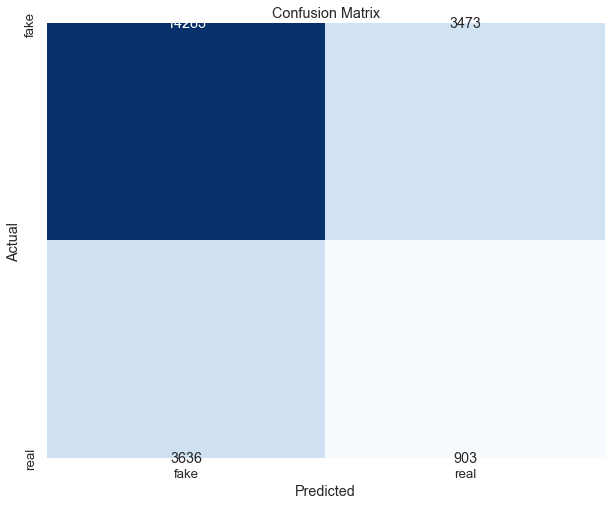

In [41]:
# Evaluate the model on the validation data
val_evaluation = model.evaluate(val_gen, steps=len(val_gen))
val_accuracy = val_evaluation[1]

# Predictions on the validation data
val_predictions = model.predict(val_gen)
val_pred_classes = np.argmax(val_predictions, axis=1)

# True classes from the validation data generator
val_true_classes = val_gen.classes

# Retrieve class labels (class names) from the generator
class_names = list(val_gen.class_indices.keys())

# Calculate the confusion matrix
confusion = confusion_matrix(val_true_classes, val_pred_classes)

# Create a heatmap of the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [42]:
a3 = history.history['accuracy'][-1]
f3 = history.history['f1_score'][-1]
p3 = history.history['precision_m'][-1]
r3 = history.history['recall_m'][-1]
mae3 = history.history['mae'][-1]
mse3 = history.history['mse'][-1]
specificity3 = history.history['specificity_m'][-1]  
sensitivity3 = history.history['sensitivity_m'][-1]
print('Accuracy = ' + str(a3 * 100))
print('Precision = ' + str(p3 * 100))
print('F1 Score = ' + str(f3 * 100))
print('Recall = ' + str(r3 * 100))
print('MAE = ' + str(mae3))
print('MSE = ' + str(mse3))
print('Sensitivity = ' + str(sensitivity3 * 100))  
print('Specificity = ' + str(specificity3 * 100))

Accuracy = 99.38997626304626
Precision = 99.39024448394775
F1 Score = 99.39024448394775
Recall = 99.39024448394775
MAE = 0.009542413055896759
MSE = 0.004717655945569277
Sensitivity = 99.39024448394775
Specificity = 99.39024448394775


# Comparison

In [43]:
results ={'Accuracy': [a,a1,a2,a3],
 'Recall':[r,r1,r2,r3],
 'Precision': [p,p1,p2,p3],
  'F1 Score' : [f,f1,f2,f3],
    'Sensitivity' : [sensitivity,sensitivity1,sensitivity2,sensitivity3],
    'Specificity' : [specificity,specificity1,specificity2,specificity3],
   'MAE' : [mae,mae1,mae2,mae3],
    'MSE' : [mse,mse1,mse2,mse3]}
index = ['InceptionResnet V2','VGG19','CNN','Xception']

In [44]:
results =pd.DataFrame(results,index=index)

In [45]:
print(results)

                    Accuracy    Recall  Precision  F1 Score  Sensitivity  \
InceptionResnet V2  0.918432  0.918415   0.918415  0.918415     0.918415   
VGG19               0.796416  0.796435   0.796435  0.796435     0.796435   
CNN                 0.987048  0.987036   0.987036  0.987036     0.987036   
Xception            0.993900  0.993902   0.993902  0.993902     0.993902   

                    Specificity                                   MAE  \
InceptionResnet V2     0.918415  <function mae at 0x00000204027E2288>   
VGG19                  0.796435                               0.32427   
CNN                    0.987036                              0.019514   
Xception               0.993902                              0.009542   

                                                     MSE  
InceptionResnet V2  <function mse at 0x00000204027E23A8>  
VGG19                                           0.162385  
CNN                                             0.009877  
Xception         

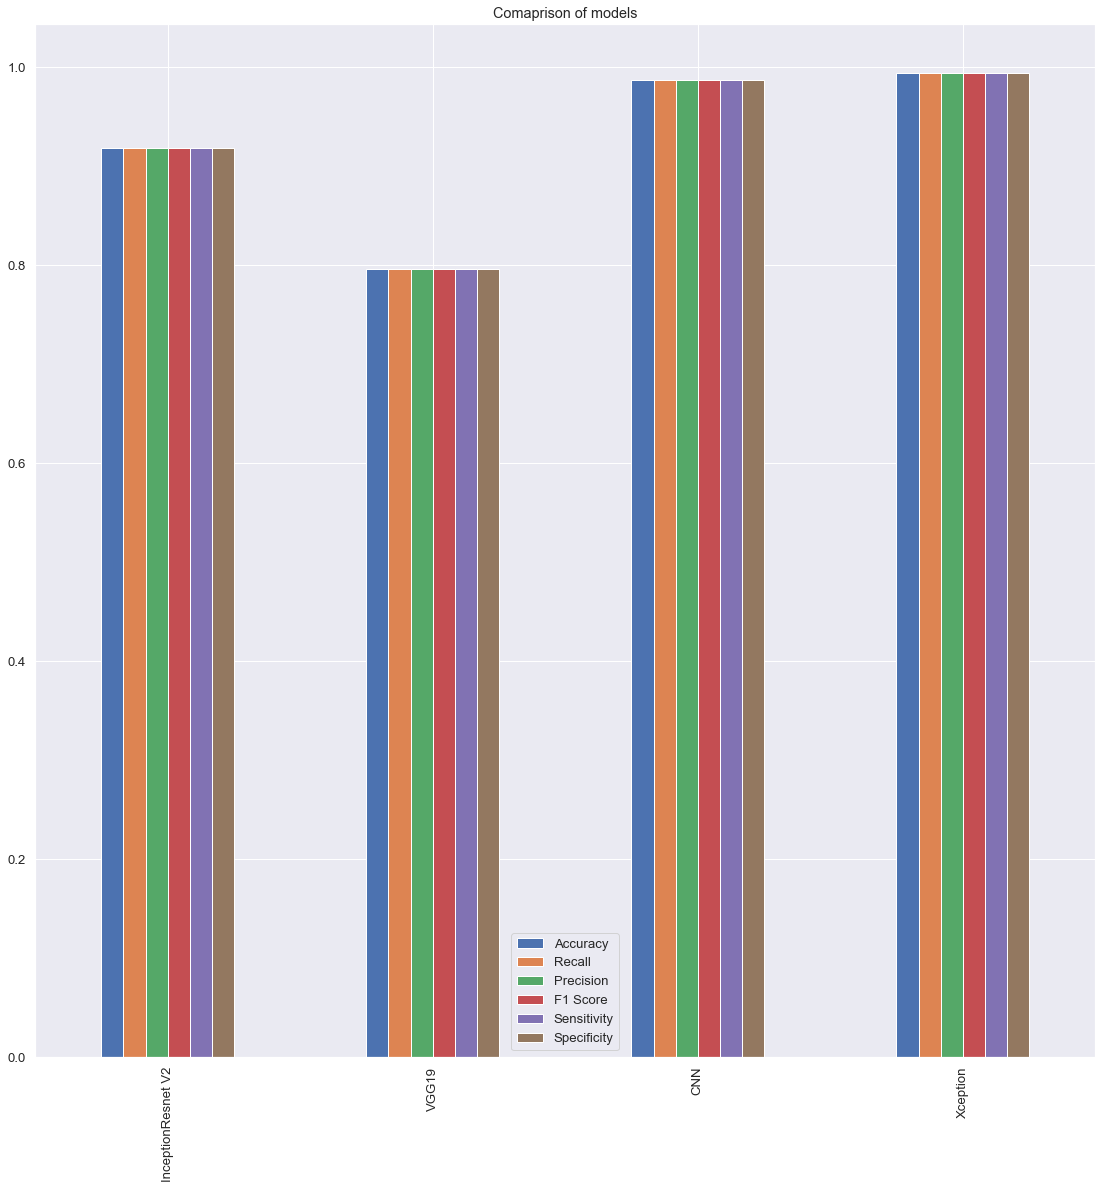

In [46]:
fig =results.plot(kind='bar',title='Comaprison of models',figsize =(19,19)).get_figure()
fig.savefig('Final Result.png')

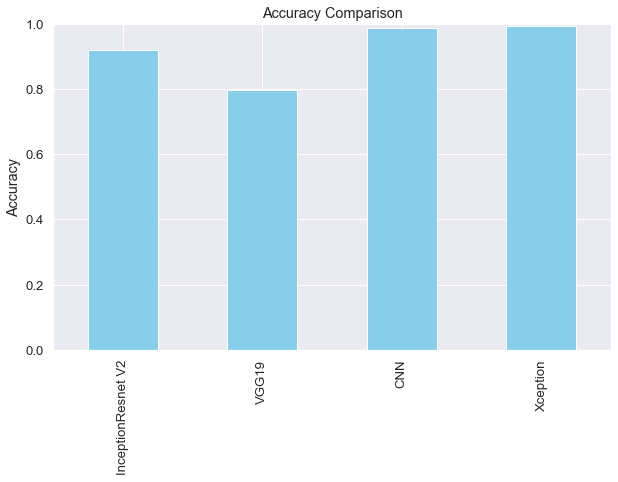

In [47]:
results_df = pd.DataFrame(results, index=['InceptionResnet V2', 'VGG19', 'CNN', 'Xception'])

# Plotting Accuracy
plt.figure(figsize=(10, 6))
results_df['Accuracy'].plot(kind='bar', color='skyblue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

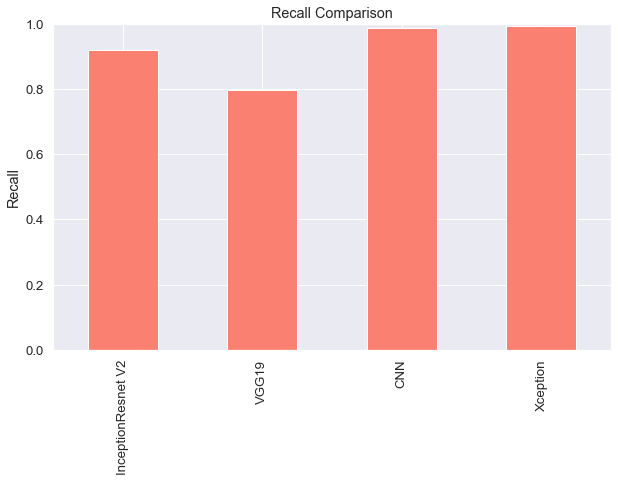

In [48]:
plt.figure(figsize=(10, 6))
results_df['Recall'].plot(kind='bar', color='salmon')
plt.title('Recall Comparison')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.show()

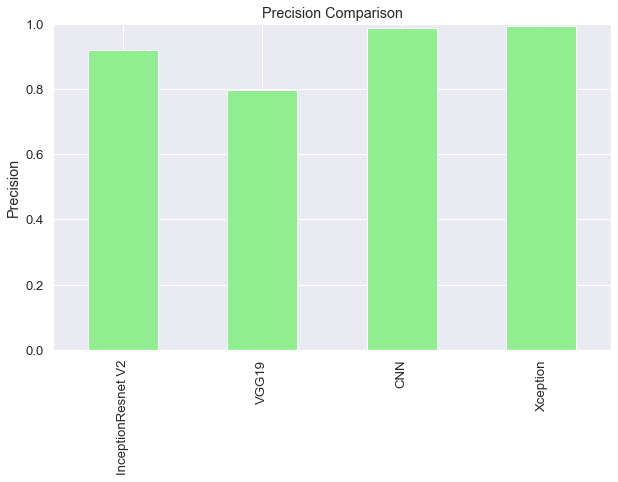

In [49]:
plt.figure(figsize=(10, 6))
results_df['Precision'].plot(kind='bar', color='lightgreen')
plt.title('Precision Comparison')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.show()

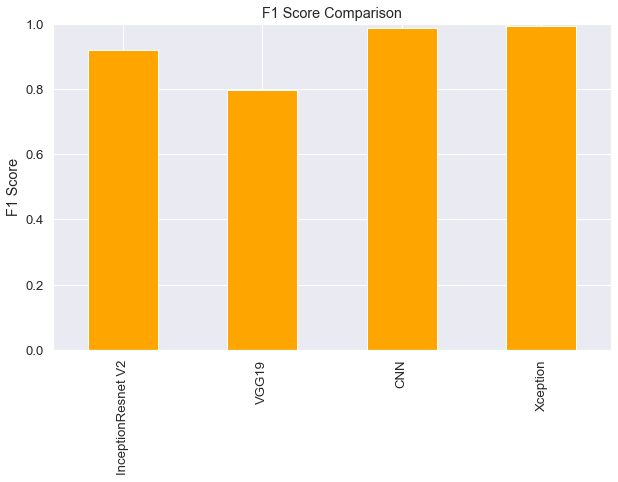

In [50]:
plt.figure(figsize=(10, 6))
results_df['F1 Score'].plot(kind='bar', color='orange')
plt.title('F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

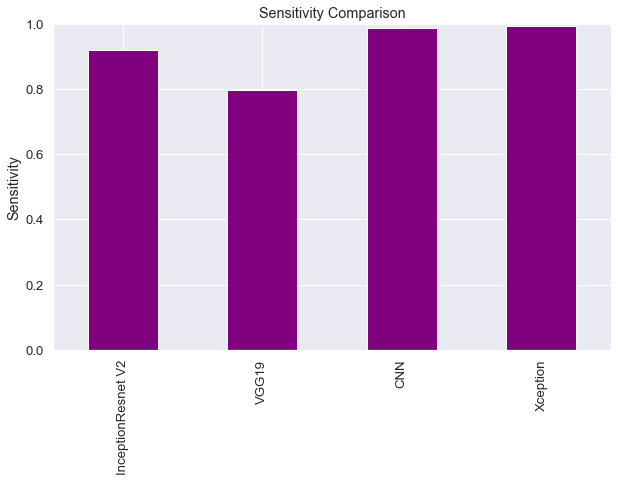

In [51]:
plt.figure(figsize=(10, 6))
results_df['Sensitivity'].plot(kind='bar', color='purple')
plt.title('Sensitivity Comparison')
plt.ylabel('Sensitivity')
plt.ylim(0, 1)
plt.show()

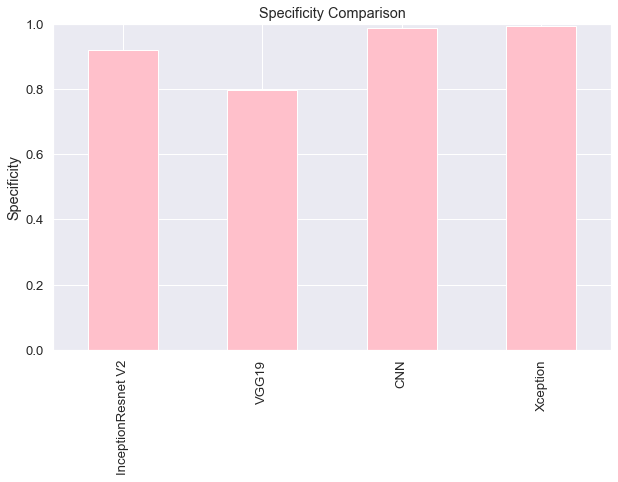

In [52]:
plt.figure(figsize=(10, 6))
results_df['Specificity'].plot(kind='bar', color='pink')
plt.title('Specificity Comparison')
plt.ylabel('Specificity')
plt.ylim(0, 1)
plt.show()